In [1]:
import cv2
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy as np
import time
import random
import pickle
import seaborn

import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model


#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn 

import warnings
warnings.filterwarnings('ignore')

print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Using TensorFlow backend.
W0514 16:45:52.225308 140634863777600 deprecation.py:323] From <ipython-input-1-8373d4af0408>:27: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF version: 2.2.0-rc2
Keras version: 2.3.1
GPU is available


In [10]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn
import cv2
import time
import random
from imutils import paths
from sklearn.utils import shuffle

## Model Load

In [2]:
#Model
num_classes=6

base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, classes=num_classes)

x = tf.keras.layers.GlobalAveragePooling2D(input_shape=base_model.output_shape[1:])(base_model.output)
x = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

#load weights
model.load_weights('../models/mobilenet_fine_trashnet_120.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

# MY Gradient class activation map (GRAD CAM)

## Prediction

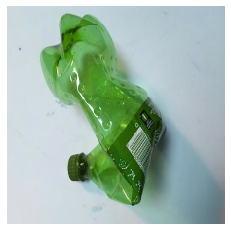

[[4.4083568e-05 4.7268798e-03 1.5085618e-04 7.1965478e-04 9.8380971e-01
  1.0548835e-02]]
bestclass plastic
4


In [25]:
#my_test_path = "../images/glass.jpeg"
my_test_path = "../images/plastic471.jpg"
#my_test_path = "../images/20190816_103719.jpg"

target_size = (224, 224)

img = cv2.imread(my_test_path)
img = cv2.resize(img, target_size)

plt.imshow(img)
plt.axis('off')
plt.show()

img = np.array(img, dtype="float") / 255.0
img_data = np.expand_dims(img, axis=0)

result_pred = model.predict(img_data, batch_size=1) 
print(result_pred)

labels = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
bestclass = labels[np.argmax(result_pred, axis=1)[0]]
print("bestclass", bestclass)

argmax = np.argmax(result_pred, axis=1)[0]
print(argmax)

## GRAD CAM

Text(0.5, 1.0, 'PLASTIC')

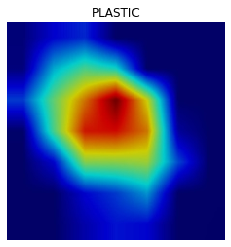

In [26]:
output = model.output[:, argmax]

last_conv_layer = model.get_layer('conv_pw_13')
grads = tf.keras.backend.gradients(output, last_conv_layer.output)[0]
pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))
iterate = tf.keras.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_data])

    
for i in range(last_conv_layer.output.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img

output = '../images/gradcam_result/gradcam.jpg'

cv2.imwrite(output, superimposed_img)

img_output = mpimg.imread(output)

plt.imshow(img_output)
plt.axis('off')
plt.title(bestclass.upper())